### Trabalho de Programação

# Análise de dados de manchas solares 

#### Janaina Fernandes

## Manchas solares
<img src="manchas.jpg">



*Notas*

As manchas solares são a contagem de manchas na face visível do sol. Nenhuma mancha indica atividade mínima, é possível perceber que as manchas estão relacionadas com o ciclo magnético do sol e são produzidas por um processo de dínamo hidromagnético.

Da mesma forma que em um dínamo eletromagnético temos uma espira rotacionando em um campo magnético temos um fluxo espiral de plasma (que também são bons condutodes de calor) dentro do sol.

O modelo atual prevê dois dínamos acoplados.



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

import seaborn as sns                            

from dateutil.relativedelta import relativedelta 
from scipy.optimize import minimize              

import statsmodels.formula.api as smf            
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    
from tqdm import tqdm_notebook

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

%matplotlib inline

/home/janarf/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


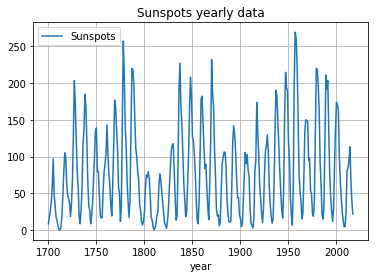

In [2]:
dfy = pd.read_csv('SN_y_tot_V2.0.csv', sep=';', header=None)
dfy.columns = ['year','Sunspots','std','observations','verified']
dfy = dfy[['year','Sunspots']]
dfy.year = dfy.year-0.5
dfy_idx = dfy.set_index(['year'], drop=True)
data = dfy_idx[['Sunspots']]
data.plot(y='Sunspots')
plt.title('Sunspots yearly data')
plt.grid(True)

plt.show()

### Proposta inicial:

Análise de dados de manchas solares no tempo e possível predição de ciclos futuros utilizando técnicas de Machine Learning. 

Utilizar autoencoders de CNN para melhorar o modelo teórico estabelecido.

### Dificuldades encontradas:


Dados e código do modelo teórico não disponíveis, análise teórica estatística, falta de familiaridade com a manipulação de séries temporais, dificuldade em encontrar códigos com abordagem prática devido às aplicações de séries temporais no mercado financeiro, necessidade de [feature design](http://www.cs.ucr.edu/~eamonn/meaningless.pdf) para a manipulação desse tipo de dado.

### Novo objetivo:

Análise exploratória dos dados de manchas solares, visualização, análise estatística e aplicação de métodos "clássicos": livro com abordagem prática para análise de séries temporais.

# Practical Time Series Analysis

### Master Time Series Data Processing, Visualization and Modeling using Python

Dr. Avishek Pal, Dr. PKS Prakash



*Notas*

livro de set/2017 - Atual

escrito por dois cientistas de dados

Modelos estatísticos + machine learning

## Capítulo 1: Introdução a Séries Temporais

### Diferentes tipos de dados

-  Dados de corte transversal (cross-section)
-  Série temporal
-  Dados em painel (panel data)


*Notas*

dados de corte transversal: dados como o pib de uma lista de países no ano passado, dados descritivos da população brasileira, votação nas últimas eleições.

série temporal: dados de manchas solares, bolsa de valores, brl - usd

dados em painel: acompanhar os dados de corte transversal ao longo de um período de tempo, evolução dos indicadores de educação no brasil em um determinado período, gastos militares de usa, china, uk e india em % do pib.

Vamos analisar somente time series a fundo já aplicando qdo possível os dados de manchas solares

### Estruturas internas de séries temporais

-  Tendência
-  Sazonalidade (seasonality)
-  Movimentos cíclicos
-  Variações inesperadas

Baseado nesse modelo uma série temporal pode ser expressa por:

$$x_t = f_t+s_t+c_t+e_t$$

*notas*

Tendencia: pode ser em forma de reta, segunda ordem, exponencial

Sazonalidade: repetições periódicas em uma serie temporal. ao retirar a tendencia é possível observar

Movimentos cíclicos: ocorrem menos frequentemente que as flutuações sazonais, pode não ter um período fixo, assim como pra identificar tendencia, podem ser necessarios dados mto antigos.

Variações inesperadas: pode ser devido a falta de informação sobre variaveis que explicam esse fenomeno ou pela presença de random noise

*Notas*

O objetivo de uma série temporal é decompor nessas características acima e desenvolver modelos matemáticos pra cada uma. Esse modelo é utilizado para avaliar causas dos dados observados e predizer pontos futuros

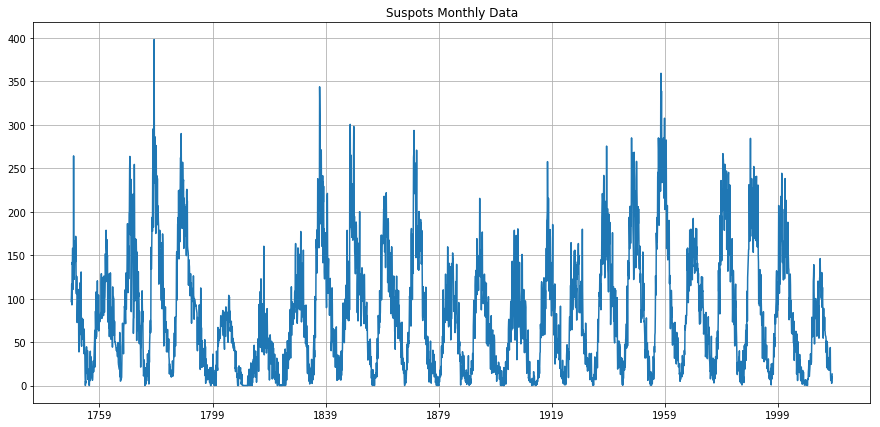

In [3]:
# Pré-tratamento dos dados
df = pd.read_csv('SN_m_tot_V2.0.csv', sep=';', header=None)
df.columns = ['year', 'month', 'FracDate', 'Sunspots', 'Std', 'Observations', 'Verified']
df = df[['year', 'month', 'Sunspots']]
df['Date'] = df.apply(lambda row: datetime(
                             int(row['year']), int(row['month']),1), axis=1)
df['Date'] = pd.to_datetime(df["Date"])
df_idx = df.set_index(["Date"], drop=True)
df_idx = df_idx.sort_index(axis=1, ascending=True)

#Plot manchas mensais
plt.figure(figsize=(15, 7))
plt.plot(df_idx.Sunspots)
plt.title('Suspots Monthly Data')
plt.grid(True)
plt.show()

### Modelos para análise de série temporal

-  Modelos de média zero
-  Random walk
-  Modelos de tendência
-  Modelos de sazonalidade


#### Modelos de média zero

Observações deste modelo são assumidas como sendo **independentes e identicamente distribuídas (iid)** e representam o random noise em torno da média fixa (subtraída da série temporal como termo constante).


#### Random walk

Dado como a soma de n iids. Pode ser reduzido ao modelo de média zero tomando as diferenças entre dois índices consecutivos:

$$ S_t-S_{t-1} = x_t$$

$x_t$ é iid com média zéro e variância constante.

#### Modelos de tendência

A escolha do modelo de tendência $\mu(t)$ é fundamental para a modelagem correta da série tempora. A análise exploratória dos dados normalmente dá dicas se devemos aplicar o modelo linear ou não linear em $t$.

$$\mu(t)=\omega t +b$$
$$\mu(t)=\omega_1 t+\omega_2 t^2 +b$$
$$\mu(t)=\omega_0 t^p +b$$

Exemplos de modelos lineares e não lineares de tendência.

#### Modelos de sazonalidade

Podem ser expressados pela soma ponderada de senos com peridiocidade conhecida:

$$s_t = \sum \frac{L}{k-1}(w_k\cos{\alpha t}+v_k\sin{\alpha t})+b$$

Também conhecido como modelo de regressão harmônica.

### Passo a passo para análise de uma série temporal

-  Visualização de dados com diferentes granularidades de tempo para revelar tendência e flutuações sazonais.
-  Identificação da tendência e plot do resíduo para identificar sazonalidade ou erro irredutível.
-  Modelo de regressão harmônica para capturar a sazonalidade.
-  Plotar o erro residual restante e identificar se é realmente erro irredutível.

### Autocorrelação e Autocorrelação parcial

Depois de aplicar as tranformações anteriores ficamos com o que é chamado de **série temporal estacionária**, caracterizada por uma média constante $E(x_t)$ e correlação dependente somente da diferença de tempo $h$ entre as duas observações e são independentes de seu valor $$E(x_t,x_{t+h})=g(h)$$ 

*Notas*

Quando normalizadas entre -1 e 1, chamamos essa relação de autocorrelação, isso garante que a série é independente do tempo e tem características que podem ser úteis na predição futura da série temporal.

correlação positiva sobe junto e negativa observáveis são inversamente proporcionais. Quanto mais próximo de zero menor a correlação e mais difícil de prever

#### Função de autocorrelação (ACF)

Plot ACF em forma de mapa para vários lags.

Plot ACF com o intervalo de confiança de 95%. Autocorrelações fora do intervalo são estatisticamente relevante, dentro do intervalo são devidas ao ruído.



#### Autocorrelação Parcial

**Modelos autoregressivos (AR)** capturam a dependencia como regressão linear entre $x_{t+h}$ e $x_t$ mas da forma calculada anteriormente a influência dos valores intermediários  $x_t, x_{t+1},...,x_{t+h-1}$ também são consideradas.

A autocorrelação parcial resolve esse problema definindo a correlação entre $x_{t+h}$ e $x_t$ desconsiderando os lags $t+1$ até $t+h-1$.

Ajuda na identificação da ordem $h$ de um modelo $AR(h)$.



*Notas*

-  Plot_pacf, pontos acima do intervalo de confiança maiores que 1 (1 sempre está acima) nos dão a ordem: 1 ponto ordem 1, 2 pontos ordem 2...

In [4]:
df_idx.head()

,Sunspots,month,year
Date,,,
1749-01-01,96.7,1,1749
1749-02-01,104.3,2,1749
1749-03-01,116.7,3,1749
1749-04-01,92.8,4,1749
1749-05-01,141.7,5,1749


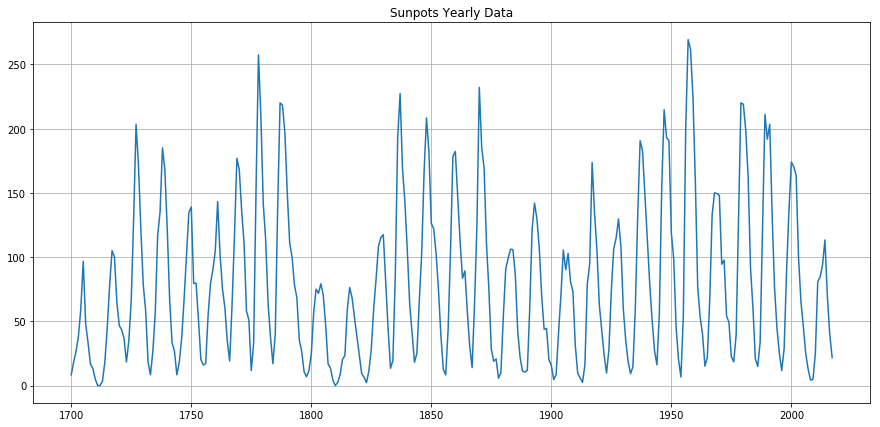

In [5]:
plt.figure(figsize=(15, 7))
plt.plot(dfy_idx.Sunspots)
plt.title('Sunpots Yearly Data')
plt.grid(True)
plt.show()

In [6]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [7]:
def moving_average(series, n):
    """
        Calcula a média das ultimas n observaçoes
    """
    return np.average(series[-n:])

moving_average(df_idx, 12) # média anual

679.7027777777778

In [8]:
moving_average(dfy_idx, 11) #média por ciclo

79.19685534591194

In [9]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = sum(abs(series[window:]- rolling_mean[window:]))/len(series[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

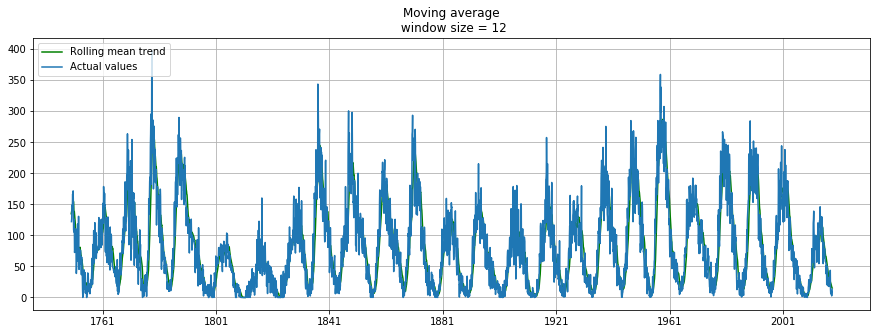

In [10]:
plotMovingAverage(df_idx.Sunspots, 12) 

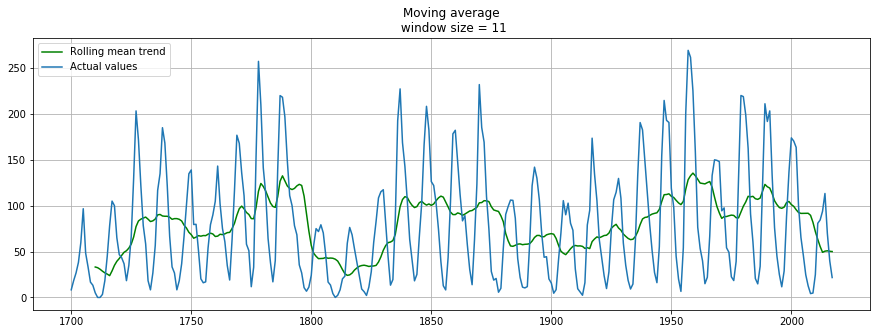

In [11]:
plotMovingAverage(dfy_idx.Sunspots, 11) 

Monthly Data


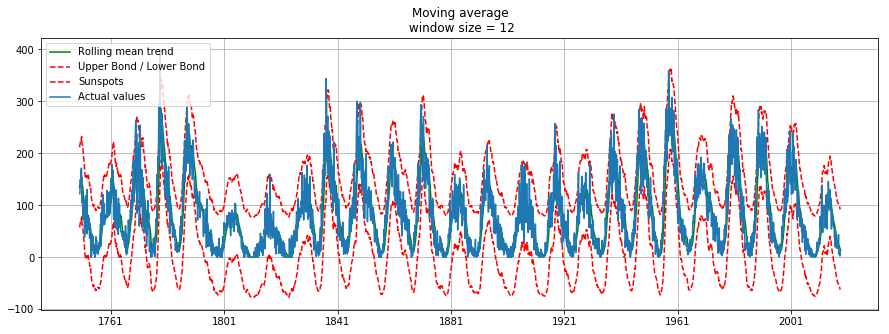

In [12]:
print('Monthly Data')
plotMovingAverage(df_idx['Sunspots'], 12,plot_intervals=True) 

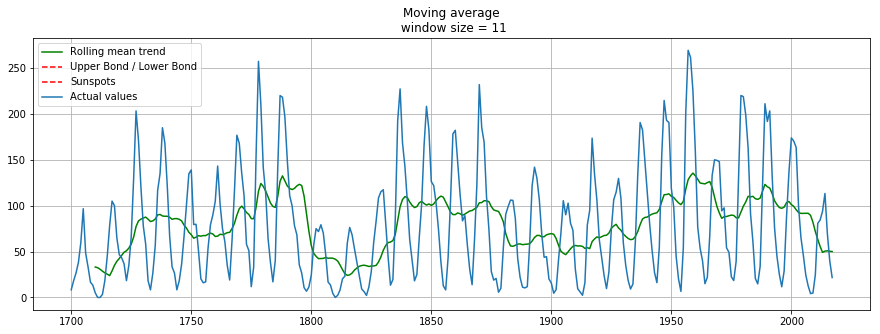

In [13]:
dfy_idx.describe()
dfy_idx.isnull().sum().sum()
plotMovingAverage(dfy_idx['Sunspots'], 11,plot_intervals=True)

In [14]:
def exponential_smoothing(series, alpha):
    """
        series - dataset with timestamps
        alpha - float [0.0, 1.0], smoothing parameter
    """
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

def plotExponentialSmoothing(series, alphas):
    """
        Plots exponential smoothing with different alphas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters
        
    """
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(15, 7))
        for alpha in alphas:
            plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
        plt.plot(series.values, "c", label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Exponential Smoothing")
        plt.grid(True);

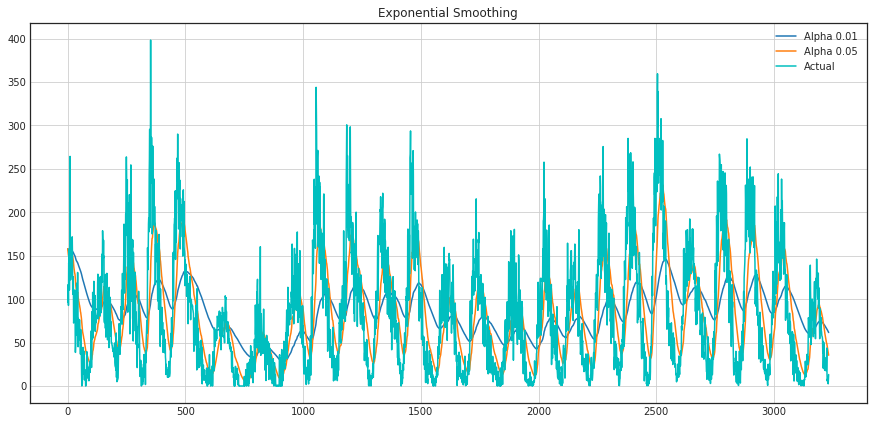

In [15]:
plotExponentialSmoothing(df_idx.Sunspots, [0.01, 0.05])

In [16]:
def double_exponential_smoothing(series, alpha, beta):
    """
        series - dataset with timeseries
        alpha - float [0.0, 1.0], smoothing parameter for level
        beta - float [0.0, 1.0], smoothing parameter for trend
    """
    # first value is same as series
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

def plotDoubleExponentialSmoothing(series, alphas, betas):
    """
        Plots double exponential smoothing with different alphas and betas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters for level
        betas - list of floats, smoothing parameters for trend
    """
    
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(20, 8))
        for alpha in alphas:
            for beta in betas:
                plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
        plt.plot(series.values, label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Double Exponential Smoothing")
        plt.grid(True)

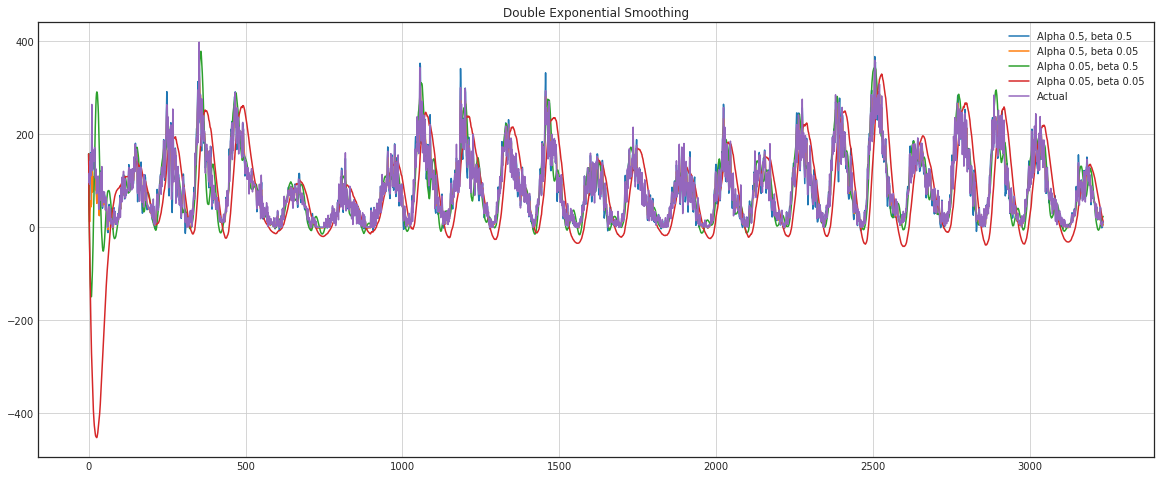

In [17]:
plotDoubleExponentialSmoothing(df_idx.Sunspots, alphas=[0.5, 0.05], betas=[0.5, 0.05])

In [18]:
df_idx.Sunspots.describe()

count    3233.000000
mean       82.526632
std        67.801181
min         0.000000
25%        24.800000
50%        68.400000
75%       123.000000
max       398.200000
Name: Sunspots, dtype: float64

In [19]:
class HoltWinters:
    
    """
    Holt-Winters model with the anomalies detection using Brutlag method
    
    # series - initial time series
    # slen - length of a season
    # alpha, beta, gamma - Holt-Winters model coefficients
    # n_preds - predictions horizon
    # scaling_factor - sets the width of the confidence interval by Brutlag (usually takes values from 2 to 3)
    
    """
    
    
    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor
        
        
    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i+self.slen] - self.series[i]) / self.slen
        return sum / self.slen  
    
    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        # let's calculate season averages
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
        # let's calculate initial values
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals   

          
    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []
        
        seasonals = self.initial_seasonal_components()
        
        for i in range(len(self.series)+self.n_preds):
            if i == 0: # components initialization
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])
                
                self.PredictedDeviation.append(0)
                
                self.UpperBond.append(self.result[0] + 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                
                self.LowerBond.append(self.result[0] - 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                continue
                
            if i >= len(self.series): # predicting
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])
                
                # when predicting we increase uncertainty on each step
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01) 
                
            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])
                
                # Deviation is calculated according to Brutlag algorithm.
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i]) 
                                               + (1-self.gamma)*self.PredictedDeviation[-1])
                     
            self.UpperBond.append(self.result[-1] + 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.LowerBond.append(self.result[-1] - 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i%self.slen])

In [20]:
from sklearn.model_selection import TimeSeriesSplit # you have everything done for you

def timeseriesCVscore(params, series, loss_function=mean_squared_error, slen=132):
    """
        Returns error on CV  
        
        params - vector of parameters for optimization
        series - dataset with timeseries
        slen - season length for Holt-Winters model
    """
    # errors array
    errors = []
    
    values = series.values
    alpha, beta, gamma = params
    
    # set the number of folds for cross-validation
    tscv = TimeSeriesSplit(n_splits=3) 
    
    # iterating over folds, train model on each, forecast and calculate error
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen=slen, 
                            alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()
        
        predictions = model.result[-len(test):]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)
        
    return np.mean(np.array(errors))

KeyboardInterrupt: 

In [ ]:
%%time
#data = df_idx.Sunspots[:-20] # leave some data for testing
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()


In [ ]:
data = df_idx[['Sunspots']]
split_date = pd.Timestamp('01-01-1964')

train = data.loc[:split_date]
test = data.loc[split_date:]

In [ ]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
train_sc = sc.fit_transform(train)
test_sc = sc.transform(test)

In [ ]:
# initializing model parameters alpha, beta and gamma
x = [0, 0, 0] 
# train_sc_df = pd.DataFrame(train_sc, columns=['Y'], index=train.index)
# test_sc_df = pd.DataFrame(test_sc, columns=['Y'], index=test.index)
data = df_idx.Sunspots[:-132]
# Minimizing the loss function 
opt = minimize(timeseriesCVscore, x0=x, 
               args=(data, mean_squared_error), 
               method="TNC", bounds = ((0, 1), (0, 1), (0, 1))
              )

# Take optimal values...
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

# ...and train the model with them, forecasting for the next 50 hours
model = HoltWinters(data, slen = 132, 
                    alpha = alpha_final, 
                    beta = beta_final, 
                    gamma = gamma_final, 
                    n_preds = 264, scaling_factor = 3)
model.triple_exponential_smoothing()

In [ ]:
def plotHoltWinters(series, plot_intervals=False, plot_anomalies=False):
    """
        series - dataset with timeseries
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
    """
    
    plt.figure(figsize=(20, 10))
    plt.plot(model.result, label = "Model")
    plt.plot(series.values, label = "Actual")
    error = np.sqrt(np.sum((series.values-model.result[:len(series)])*(series.values-model.result[:len(series)]))/len(series))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    
    if plot_anomalies:
        anomalies = np.array([np.NaN]*len(series))
        anomalies[series.values<model.LowerBond[:len(series)]] = \
            series.values[series.values<model.LowerBond[:len(series)]]
        anomalies[series.values>model.UpperBond[:len(series)]] = \
            series.values[series.values>model.UpperBond[:len(series)]]
        plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    if plot_intervals:
        plt.plot(model.UpperBond, "r--", alpha=0.5, label = "Up/Low confidence")
        plt.plot(model.LowerBond, "r--", alpha=0.5)
        plt.fill_between(x=range(0,len(model.result)), y1=model.UpperBond, 
                         y2=model.LowerBond, alpha=0.2, color = "grey")    
        
    plt.vlines(len(series), ymin=-50, ymax=+400, linestyles='dashed')
    plt.axvspan(len(series)-132, len(model.result), alpha=0.3, color='lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13);

In [ ]:
plotHoltWinters(df_idx.Sunspots)

In [ ]:
plotHoltWinters(df_idx.Sunspots,plot_intervals=True,plot_anomalies=True)

In [ ]:
plt.figure(figsize=(20, 5))
plt.plot(model.PredictedDeviation)
plt.grid(True)
plt.axis('tight')
plt.title("Brutlag's predicted deviation");

In [ ]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

In [ ]:
tsplot(dfy_idx.Sunspots, lags=40)

In [ ]:
ads_diff = df_idx.Sunspots - df_idx.Sunspots.shift(11)
tsplot(ads_diff[11:], lags=60)

In [ ]:
ads_diff = ads_diff - ads_diff.shift(1)
tsplot(ads_diff[132+1:], lags=60)

In [ ]:
tsplot(dfy_idx.Sunspots, lags=40)

In [ ]:
df = pd.read_csv('SN_y_tot_V2.0.csv', sep=';', header=None)
df.columns = ['year', 'Sunspots', 'Std', 'Observations', 'Verified']

df['Date'] = df.apply(lambda row: datetime(
                              int(row['year']), 12,31), axis=1)
df['Date'] = pd.to_datetime(df["Date"])
dfy_idx = df.set_index(["Date"], drop=True)
dfy_idx.head()

In [ ]:
arma_mod20 = sm.tsa.statespace.SARIMAX(dfy_idx.Sunspots, order=(2,0,0), trend='c').fit(disp=False)
print(arma_mod20.params)
print(arma_mod20.aic, arma_mod20.bic, arma_mod20.hqic)


In [ ]:
arma_mod30 = sm.tsa.statespace.SARIMAX(dfy_idx.Sunspots, order=(3,0,0), trend='c').fit(disp=False)
print(arma_mod30.params)
print(arma_mod30.aic, arma_mod30.bic, arma_mod30.hqic)


In [ ]:
sm.stats.durbin_watson(arma_mod30.resid)

In [ ]:
resid = arma_mod30.resid

In [ ]:
tsplot(resid, lags=40)

In [ ]:
from statsmodels.graphics.api import qqplot

fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(111)
fig = qqplot(resid, line='q', ax=ax, fit=True)


In [ ]:
predict_sunspots = arma_mod30.predict(start='1700', end='2030', dynamic=False)

In [ ]:
arma_mod302 = sm.tsa.statespace.SARIMAX(dfy_idx.Sunspots, order=(3,0,2),trend='c').fit(disp=True)
predict_sunspots = arma_mod302.predict(start='1700', end='2030', dynamic=False)

In [ ]:
dfy_idx.Sunspots[:-50].tail()

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))

dfy_idx.Sunspots.plot(ax=ax)
#dfy_idx.Sunspots.loc['1950':].plot(ax=ax)
predict_sunspots.plot(ax=ax, style='--r');

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))

dfy_idx.Sunspots.plot(ax=ax)
#dfy_idx.Sunspots.loc['1950':].plot(ax=ax)
predict_sunspots.plot(ax=ax, style='--r');

In [ ]:
def mean_forecast_err(y, yhat):
    return y.sub(yhat).mean()

In [ ]:
mean_forecast_err(dfy_idx.Sunspots, predict_sunspots)


## Capítulo 2: Entendendo os dados de uma série temporal

<img src="fluxograma.png">


### Processos estacionários

Um **processo estacionário** requer que média, variância e autocorrelação sejam invariantes com respeito ao tempo da observação.

No entanto, a maioria dos processos reais em séries temporais não são estacionários. Uma etapa crucial na análise de séries temporais é verificar se uma série é estacionária e métodos para tornar processos não estácionários em estacionários, removendo tendência e sazonalidade.

### Diferenciação

Podendo ser de primeira ordem ou de segunda ordem para eliminação da tendência:

$$\dot{x}_t = (x_t-x_{t-1})$$
$$\ddot{x}_t = (\dot{x}_t-\dot{x}_{t-1})= (x_t-x_{t-1})-(x_{t-1}-x_{t-2})$$

Se a série temporal tem sazonalidade com período conhecido $m$ a difereciação retira este efeito da série:

$$\dot{x}_t = x_t-x_{t-m} = \epsilon_t$$

### Teste de Dickey-Fuller aumentado

Teste com $H_0$ sendo um processo não estacionário e a hipótese alternativa um processo estácionário.


### Decomposição de uma série temporal

-  Modelo aditivo 
$$x_t=F_t+S_t+\epsilon_t$$
-  Modelo multiplicativo
$$x_t=F_t+S_t+\epsilon_t$$
$$\log{x_t}=\log{F_t}+\log{S_t}+\log{\epsilon_t}$$


### Médias móveis

**Médias móveis (MA)** estimam a tendência média calculada pela média no período de $t\pm k$ onde $k$ é o alcance da MA:

$$F_t=\frac{x_{t-k}+x_{t-k+1}+...+x_t+...+x_{t+k}}{2k+1}$$

Usualmente nos referimos ao número total de observações $m=2k+1$ como a MA de ordem $m$.

As médias móveis podem ser usadas para a suavização dos gráficos, foram descritas de forma simétrica a $x_t$ para o caso de $m$ ímpar mas podemos considerar ainda médias assimétricas $m=2k$.

A assimetria de uma MA de ordem par pode ser eliminada tomando a segunda MA de ordem par. Como por exemplo no caso de $m=2$:

$$F_t^{(2)}=\frac{x_{t-1}+x_{t}}{2}$$

Aplicando uma segunda média móvel de segunda ordem à série $F_t^{(2)}$ produziremos uma média movel final simétrica:

$$2\times F_t^{(2)}=\frac{F_t^{(2)}+F_{t+1}^{(2)}}{2}=\frac{1}{2}\times \frac{x_{t-1}+x_t}{2}+\frac{x_{t}+x_{t+1}}{2}$$

$$=\frac{1}{4}x_{t-1}+\frac{1}{2}x_t+\frac{1}{4}x_{t+1}$$


Em geral, podemos criar as médias móveis $n\times F_t^{(m)}$ tomando primeiro a média de ordem $m$ seguida da média de ordem $n$. Para produzir uma MA simétrica $n$ e $m$ devem ser os dois pares ou os dois ímpares.

*Notas*

Uma característica importante é que podemos chamar de média móvel ponderada, quanto mais próximo de $x_t$ maior o peso dado à variável, o que gera um conjunto de dados com curva mais suave.

### Ajuste sazonal usando médias móveis

Podemos utilizar as séries $n\times F_t^{(m)}$ descritas anteriormente como médias ponderadas que podem ser aplicadas para suavizar dados com sazonalidade para gerar estimativas de tendência. Por exemplo para dados trimestrais podemos aplicar $2\times F_t^{(4)}$ (4 é o número de trimestres em um ano). A MA é tratada como a tendência dos dados e o resíduo avaliado pelo teste ACF.


### Decomposição de série temporal

#### Por médias móveis

Pela abordagem descrita temos que:

$$\epsilon_t=x_t-F_t-S_t$$
No modelo aditivo.

$$\epsilon_t=\frac{x_t}{F_t\times S_t}$$
No modelo multiplicativo.

#### Usando statsmodels.tsa

Pacote que já tem esses modelos e precisamos apenas dar os parâmetros da decomposição.

## Capítulo 3: Métodos baseados em suavização exponencial

O processo de predição baseado na suavização exponencial pode ser resumido como filtros que tomam inputs e separam os componentes tendência e ruído como na figura:

FIGURA CAP 3



### Suavização exponencial de primeira ordem

É plicada em dados de variância constante e sem sazonalidade. Essa abordagem é recomendada para predições de curto prazo.

A fórmula geral é dada por:
$$x_t=\alpha x_t+(1-\alpha)x_{t-1}$$

Aqui, o modelo é a média ponderada entre o valor atual e o valor anterior com um fator de suavização $\alpha$ que nos dá o quão rápido ''esqueceremos'' a última observação. Quanto menor o $\alpha$ maior é a influência dos valores anteriores e mais suave é a série.

A recursividade exponencial está na multiplicação a cada $t$ por $(1-\alpha)$.

A acurácia do modelo pode ser avaliada por funções como o **erro absoluto médio (MAS)** e o **erro quadrado médio (MSE)**

$$MSE =\frac{1}{N} \sum ^N_{i=1}(x_t-F_t)^2$$

$$MAD=\frac{1}{N} \sum ^N_{i=1}|x_t-F_t|$$

### Suavização exponencial de segunda ordem

Aplicaremos a suavização anterior à tendência assumindo que a direção das mudanças da série temporal dependem da diferença dos pesos anteriores. Como resuldados tempos as seguintes funções com nível $\ell$ e tendência $b$:

$$\ell_t = \alpha x_t + (1-\alpha)(\ell_{t-1} + b_{t-1})$$

$$b_t = \beta(\ell_t - \ell_{t-1}) + (1-\beta)b_{t-1}$$

$$x_{t+1} = \ell_t + b_t$$

$\beta$ é o coeficiente de suavização da segunda exponencial. A predição é a soma do modelo de valores de $\ell$ e $b$.

Agora temos dois parâmetros $\alpha$ e $\beta$. O primeiro suaviza a curva em torno da tendência e o segundo suaviza a própria tendência.

## Capítulo 4: Modelos Autorregressivos

### Modelos autorregressivos
**Modelos autorregressivos (AR)** são modelos estatísticos muitos bons em predição de séries temporais em que os valores seguintes dependem dos valores anteriores. Assim, modelos AR são muito utilizados na predição de séries temporais.

Os modelos autorregressivos são definidos como AR$(p)$ onde $p$ é a ordem do comporente AR.

O modelo AR de primeira ordem, AR(1):
$$x_t=\phi x_{t-1}+\in_t$$

AR(2):

$$x_t=\phi_1 x_{t-1}+\phi_2 x_{t-2}+\in_t$$

O modelo AR de p-ésima ordem, AR$(p)$:
$$x_t=\phi_1 x_{t-1}+\phi_2 x_{t-2}+...+\phi_p x_{t-p}+\in_t$$

$\phi$ é o coeficiente do modelo, $\in_t\approx N(0,\sigma^2)$ é o erro no tempo $t$.

### Modelos de Médias Móveis:

Similarmente ao modelo AR o **modelo de médias móvias (MA)** tem o mesmo objetivo e ordem $q$, porém nestes modelos a suposição é que o erro atual depende do erro anterior.

### Modelo ARMA 

A combinação dos modelos anteriores AR$(p)$ e MA$(q)$ forma o modelo ARMA$(p,q)$:

$$ x_t = \alpha + \phi_1 x_{t-1} + \phi_2 x_{t-2} +...+ \phi_p x_{p-q}-\theta_1\epsilon_{t-1}-\theta_2\epsilon_{t-2}-...-\theta_q\epsilon_{t-q}+\epsilon_t $$

Algumas regras gerais para selecionar o $p$ e $q$ do modelo ARMA a ser utilizado:

-  Autocorrelação decrescente exponencialmente e PACF com correlação significativa usando lag 1, então usamos o parâmetro $p$
-  Autocorrelação formando um padrão seno e PACF com correlação significativa com lags 1 e 2, usamos $p=2$
-  Autocorrelação é significativa e PACF cai exponencialmente, usar parâmetro $q$
-  Autocorrelação é significativa e PACF tem padrão seno, usar parâmetro $q$



### Modelo ARIMA

É uma generalização do modelo ARMA que inclui componentes integradas.

Uma extensão importante do modelo ARIMA é a inclusão da sazonalidade no modelo. Ele possui então seis parâmetros ARIMA$(p,d,q)(P,D,Q)_m$ onde P, D e Q representam a parte sazonal do modelo autorregressivo. O $m$ é o número de períodos na série.


## Capítulo 5: Deep Learning para predição de série temporal




A ideia de predição linear pode ser generalizada em seu objetivo principal: desenvolver uma função $f$ que prediz $x_t$ a partir de observações em tempos $p$ anteriores:

$$x_t=f(x_{t-1},x_{t-2},...,x_{t-p})$$

Os métodos apresentados neste capítulo encontam o $f$ a partir da definição de redes neurais (podem variar o número de *hidden layers*, o número de neurons) e do seu treinamento (usando *backpropagation* ou alguma variante apropriada para a aquitetura da rede neural usada).



*Notas*

Chamamos de **deep learning** uma gama de métodos de aprendizado de máquinas mas o mais conhecido são as redes neurais com muitas *hidden layers*.

A arquitetura da rede neural deve ser adequada aos dados de entrada e saída, por exemplo: **redes neurais convolucionais (CNN)** são mais apropriadas para dados estruturados em 2D ou 3D (muito utilizada na classificação de imagens) enquanto **redes neurais recorrentes (RNN)** são utilizadas para modelos de análise de linguagem.

A análise de séries temporais tem se mostrado promissora.



### O que são as redes neurais

<img src="tirinha.jpeg">



### A estrutura dos neurons

<img src="neuron.png">
<img src="neuronart.jpg">



<img src="neuralnetworks.png">


In [ ]:
df = pd.read_csv('SN_d_tot_V2.0.csv', sep=';', header=None)
df.columns = ['year', 'month','day', 'FracDate', 'Sunspots', 'Std', 'Observations', 'Verified']
df = df[['year','month','day', 'Sunspots']]
df['Date'] = df.apply(lambda row: datetime(
                              int(row['year']), int(row['month']),int(row['day'])), axis=1)

df['Date'] = pd.to_datetime(df["Date"])
df_idx = df.set_index(["Date"], drop=True)

daily_sun= df[['Date','Sunspots']]#df.head()
daily_sun = daily_sun.set_index(["Date"], drop=True)
daily_sun.head()

In [ ]:
daily_sun = daily_sun.sort_index(axis=1, ascending=True)
daily_sun = daily_sun.iloc[::-1]
daily_sun.head(10)

In [ ]:
data = daily_sun[['Sunspots']]
data.plot(y='Sunspots')
plt.show()

In [ ]:
diff = data.index.values[-1] - data.index.values[0]
days = diff.astype('timedelta64[D]')
days = days / np.timedelta64(1, 'D')
years = int(days/365)
print("Total data: %d years"%years)
print("80 percent data = 1749 to %d"%(1818 + int(0.8*years)))

In [ ]:
split_date = pd.Timestamp('01-01-1978')

train = data.loc[:split_date]
test = data.loc[split_date:]

ax = train.plot(figsize=(10,12))
test.plot(ax=ax)
plt.legend(['train', 'test'])
plt.show()

In [ ]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
train_sc = sc.fit_transform(train)
test_sc = sc.transform(test)

In [ ]:
train_sc_df = pd.DataFrame(train_sc, columns=['Y'], index=train.index)
test_sc_df = pd.DataFrame(test_sc, columns=['Y'], index=test.index)

for s in range(1,2):
    train_sc_df['X_{}'.format(s)] = train_sc_df['Y'].shift(s)
    test_sc_df['X_{}'.format(s)] = test_sc_df['Y'].shift(s)

X_train = train_sc_df.dropna().drop('Y', axis=1)
y_train = train_sc_df.dropna().drop('X_1', axis=1)

X_test = test_sc_df.dropna().drop('Y', axis=1)
y_test = test_sc_df.dropna().drop('X_1', axis=1)

X_train = X_train.as_matrix()
y_train = y_train.as_matrix()

X_test = X_test.as_matrix()
y_test = y_test.as_matrix()

In [ ]:
print('Train size: (%d x %d)'%(X_train.shape[0], X_train.shape[1]))
print('Test size: (%d x %d)'%(X_test.shape[0], X_test.shape[1]))

### Modelo SVM regressivo

In [ ]:
from sklearn.svm import SVR
regressor = SVR(kernel='rbf')

In [ ]:
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

In [ ]:
plt.plot(y_test)
plt.plot(y_pred)
plt.legend(['train', 'test'])
plt.title('Regressive SVM Model')

In [ ]:
from sklearn.metrics import r2_score

def adj_r2_score(r2, n, k):
    return 1-((1-r2)*((n-1)/(n-k-1)))

r2_test = r2_score(y_test, y_pred)
print("R-squared is: %f"%r2_test)

## Usando Redes Neurais

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import keras.backend as K

### 1 hidden layer com 1 neuron

In [ ]:
K.clear_session()
model = Sequential()
model.add(Dense(1, input_shape=(X_test.shape[1],), activation='tanh', kernel_initializer='lecun_uniform'))
model.compile(optimizer=Adam(lr=0.0001), loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=6, epochs=6, verbose=1)

In [ ]:
y_pred = model.predict(X_test)
plt.plot(y_test)
plt.plot(y_pred)
plt.legend(['train', 'test'])
plt.title('1 hidden Layer with 1 neuron')
print('R-Squared: %f'%(r2_score(y_test, y_pred)))

In [ ]:
plt.plot(y_test[len(y_test)-500:])
plt.plot(y_pred[len(y_pred)-500:])
plt.legend(['train', 'test'])
plt.title('Last predicted data')

### ANN

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.models import load_model

In [ ]:
sc = MinMaxScaler()
train_sc = sc.fit_transform(train)
test_sc = sc.transform(test)

In [ ]:
X_train = train_sc[:-1]
y_train = train_sc[1:]

X_test = test_sc[:-1]
y_test = test_sc[1:]

In [ ]:
K.clear_session()

model = Sequential()
model.add(Dense(12, input_dim=1, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=2, verbose=1)
history = model.fit(X_train, y_train, epochs=4, batch_size=1, verbose=1, callbacks=[early_stop], shuffle=False)

In [ ]:
model.save('ANN_NonShift.h5')

In [ ]:
y_pred_test_ann = model.predict(X_test)
y_train_pred_ann = model.predict(X_train)
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred_ann)))
r2_train = r2_score(y_train, y_train_pred_ann)
print("The Adjusted R2 score on the Train set is:\t{:0.3f}\n".format(adj_r2_score(r2_train, X_train.shape[0], X_train.shape[1])))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_pred_test_ann)))
r2_test = r2_score(y_test, y_pred_test_ann)
print("The Adjusted R2 score on the Test set is:\t{:0.3f}".format(adj_r2_score(r2_test, X_test.shape[0], X_test.shape[1])))

## LSTM

In [ ]:
X_tr_t = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_tst_t = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [ ]:
from keras.layers import LSTM
K.clear_session()
model_lstm = Sequential()
model_lstm.add(LSTM(7, input_shape=(1, X_train.shape[1]), activation='relu', kernel_initializer='lecun_uniform', return_sequences=False))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
history_model_lstm = model_lstm.fit(X_tr_t, y_train, epochs=4, batch_size=1, verbose=1, shuffle=False, callbacks=[early_stop])

y_pred_test_lstm = model_lstm.predict(X_tst_t)
y_train_pred_lstm = model_lstm.predict(X_tr_t)
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred_lstm)))
r2_train = r2_score(y_train, y_train_pred_lstm)
print("The Adjusted R2 score on the Train set is:\t{:0.3f}\n".format(adj_r2_score(r2_train, X_train.shape[0], X_train.shape[1])))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_pred_test_lstm)))
r2_test = r2_score(y_test, y_pred_test_lstm)
print("The Adjusted R2 score on the Test set is:\t{:0.3f}".format(adj_r2_score(r2_test, X_test.shape[0], X_test.shape[1])))

In [ ]:
model_lstm.save('LSTM_NonShift.h5')

### Avaliação dos modelos

In [ ]:
model_ann = load_model('ANN_NonShift.h5')
model_lstm = load_model('LSTM_NonShift.h5')

In [ ]:
score_ann= model_ann.evaluate(X_test, y_test, batch_size=1)
score_lstm= model_lstm.evaluate(X_tst_t, y_test, batch_size=1)

In [ ]:
print('ANN: %f'%score_ann)
print('LSTM: %f'%score_lstm)

In [ ]:
y_pred_test_ANN = model_ann.predict(X_test)
y_pred_test_LSTM = model_lstm.predict(X_tst_t)

In [ ]:
col1 = pd.DataFrame(y_test, columns=['True'])
col2 = pd.DataFrame(y_pred_test_ANN, columns=['ANN_prediction'])
col3 = pd.DataFrame(y_pred_test_LSTM, columns=['LSTM_prediction'])
col4 = pd.DataFrame(history.history['loss'], columns=['Loss_ANN'])
col5 = pd.DataFrame(history_model_lstm.history['loss'], columns=['Loss_LSTM'])
results = pd.concat([col1, col2, col3, col4, col5], axis=1)
results.to_excel('PredictionResults_ANN-LSTM_NonShift.xlsx')

In [ ]:
plt.plot(y_test, label='True')
plt.plot(y_pred_test_ANN, label='ANN')
plt.title("ANN's_Prediction")
plt.xlabel('Observation')
plt.ylabel('Sunspots_Scaled')
plt.legend()
plt.show()

In [ ]:
plt.plot(y_test, label='True')
plt.plot(y_pred_test_LSTM, label='LSTM')
plt.title("LSTM's_Prediction")
plt.xlabel('Observation')
plt.ylabel('Sunspots_Scaled')
plt.legend()
plt.show()